In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('TkAgg')
import matplotlib as mpl
import numpy as np
import scipy
from IPython.display import Image
from qutip import *
from math import sqrt


from qutip.qip.device import Processor
from qutip_qip.device import CavityQEDModel
from qutip_qip.device import DispersiveCavityQED
from qutip.qip.compiler import CavityQEDCompiler
from qutip.qip.pulse import Pulse
from qutip.operators import sigmaz, sigmay, sigmax, destroy
from qutip.states import basis
from qutip.metrics import fidelity
from qutip.qip.operations import rx, ry, rz, hadamard_transform, cphase
from qutip_qip.circuit import QubitCircuit, Gate
from qutip.qip.operations import cnot, snot


#https://nbviewer.ipython.org/github/qutip/qutip-notebooks/blob/master/examples/qip-randomized-benchmarking.ipynb

In [3]:
GHz = 10**9 #Hz
wq1 = 3.04 #* GHz # 6.617 * GHz * 2* np.pi # wq = sqrt(8EjEc)
wq2 = 3.00 #* GHz # 2.88 * GHz * 2* np.pi # 6.529 * GHz * 2* np.pi
wc = 3  #* GHz # 5.19 * GHz * 2 * np.pi
g1 = 0.04 #* GHz  # 0.105 * GHz * 2 * np.pi
g2 = 0.04 #* GHz # g1
f = 0.5
amp = 0.1
# cavity dissapation rate
kappa = 0#0.033 * 2 * np.pi * GHz
# qubit dissapation rate
gamma1 = 0.0#0.00261 * GHz * 2* np.pi
gamma2 = gamma1
num_qubits = 1
num_c_levels = 2

Ramsey Experiments
- Fitting to the curve
- Hadamard method

In [4]:
# add operators and make circuit
T2 = 10/f
# tlist = np.arange(0.00, 20.2, 0.2) # later

In [5]:
# https://notebook.community/qutip/qutip-notebooks/examples/qip-noisy-device-simulator
# still don't know how to add detuning of qubits
processor = DispersiveCavityQED(num_qubits=num_qubits, num_levels = num_c_levels, sx=amp/2, w0=wc, g=g1, t2=T2)
ham_idle = 2*np.pi * sigmaz()/2 * f
resonant_sx = 2*np.pi * sigmax () - ham_idle / (amp/2)
processor.add_drift(ham_idle, targets =0)
processor.add_control(resonant_sx , targets =0 , label ="sx0")

T2: 20.0
Fitted T2: 617.0922187927995


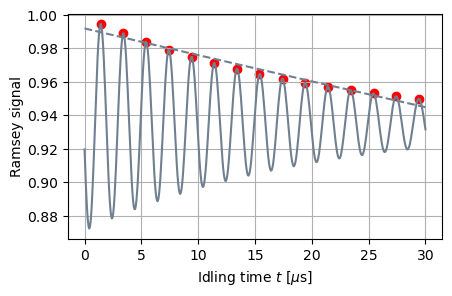

In [10]:
def ramsey(t,proc):
    qc = QubitCircuit(1)
    qc.add_gate("RX", 0 , arg_value =np.pi/2) # move the bloch vector to equator
    qc.add_gate("IDLE", 0, arg_value = t )
    qc.add_gate("RX", 0 , arg_value =np.pi/2)
    proc.load_circuit(qc)
    result = processor.run_state(init_state=tensor(basis(2,0),basis(2,0)), e_ops=tensor(sigmaz(),identity(2)),options=Options(nsteps=50000))
    return result.expect[0][-1]

num_samples=500
idle_tlist = np.linspace(0., 30., num_samples)
measurements = np.asarray([ramsey(t, processor) for t in idle_tlist])

rx_gate_time = 1/4/amp # pi/2
total_time = 2*rx_gate_time + idle_tlist[-1]
tlist = np.linspace(0., total_time, num_samples)

peak_ind = scipy.signal.find_peaks(measurements)[0]
peak_signal = measurements[peak_ind]
peak_times = idle_tlist[peak_ind]

decay_func = lambda t, t2, f0: f0 * np.exp(-1./t2 * t)
(t2_fit,f0_fit),_= scipy.optimize.curve_fit(decay_func, idle_tlist[peak_ind], measurements[peak_ind])
print("T2:", T2)
print("Fitted T2:", t2_fit)

fig, ax = plt.subplots(figsize = (5, 3), dpi=100)
ax.plot(idle_tlist[:], measurements[:], '-', label="Simulation", color="slategray")
ax.plot(idle_tlist, decay_func(idle_tlist, t2_fit, f0_fit), '--', label="Theory", color="slategray")
ax.scatter(peak_times, peak_signal, color="r")
ax.set_xlabel(r"Idling time $t$ [$\mu$s]")
ax.set_ylabel("Ramsey signal", labelpad=2)
ax.set_ylim((ax.get_ylim()[0], ax.get_ylim()[1]))
ax.set_position([0.18, 0.2, 0.75, 0.75])
ax.grid()
fig

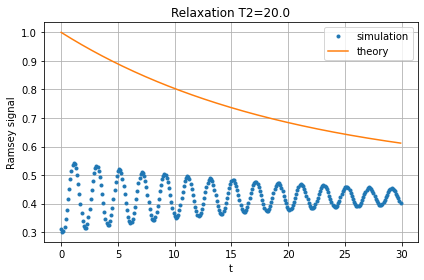

In [7]:
a = tensor(destroy(num_c_levels), qeye(2))
Hadamard = tensor(snot(), identity(num_c_levels))
# op = Hadamard*a.dag()*a*Hadamard
sm = tensor(qeye(num_c_levels), destroy(2))



def ramsey(t,proc):
    qc = QubitCircuit(1)
    qc.add_gate("RX", 0 , arg_value =np.pi/2 )
    qc.add_gate("IDLE", 0, arg_value = t )
    qc.add_gate("RX", 0 , arg_value =np.pi/2)
    proc.load_circuit(qc)
    result = processor.run_state(init_state=tensor(basis(2,1),basis(2,0)).unit(), e_ops=[a.dag()*a, Hadamard*a.dag()*a*Hadamard],options=Options(nsteps=50000))
    return result.expect[1][-1]

tlist = np.arange(0.0,30.0,0.1)
output = []
for t in tlist:
    output += [ramsey(t,processor)]
fig, ax = plt.subplots()
# # detail about length of tlist needs to be fixed
ax.plot(tlist, output, '.', label="simulation")
ax.plot(tlist, np.exp(-1./T2*tlist)*0.5 + 0.5, label="theory")
ax.set_xlabel("t")
ax.set_ylabel("Ramsey signal")
ax.legend()
ax.set_title(f"Relaxation T2={T2}")
ax.grid()
fig.tight_layout()
fig